### Problem Set 6

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.special import gamma, kv
import corner
import pickle

#### Problem 1:  Learn the hyperparameters of a Gaussian process kernel by Approximate Bayesian Computation. You will need a GP implementation (your own, or you can use scikit-learn or tinygp or whatever) in which you can make draws from the prior over functions. You will also need the small data set provided (on Discord) for this problem. And you will need to choose some broad prior over the two parameters of the Matérn 3/2 kernel. Make your convex distance function on the data directly, so that a trial function gets a good (low) score if it matches all N data points nearly exactly. Obtain a good posterior sampling with a few hundred ABC-generated posterior samples.

Below I use Latin Hypercube sampling to take samples uniformly in the N-dimensional spaces of the 2 relevant parameters of the gaussian process: $\sigma^2$ and $\tau$. I then use corner.py to plot the posterior distributions of $\sigma^2$ and $\tau$.

In [2]:
with open('data_ps6.pkl', 'rb') as f:
    xs, ys = pickle.load(f)

In [3]:

from scipy import interpolate
f = interpolate.interp1d(xs, ys)
xnew = np.random.uniform(np.min(xs), np.max(xs), len(xs))
ynew = f(xnew)   # use interpolation function returned by `interp1d`

In [4]:
xs_test = xs
xs_train = xnew
ys_test = ys
ys_train = ynew

Text(0, 0.5, '$y$')

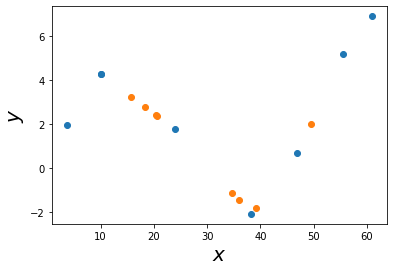

In [5]:
plt.plot(xs, ys, 'o')
plt.plot(xnew, ynew, 'o')
plt.xlabel(r'$x$', fontsize=20)
plt.ylabel(r'$y$', fontsize=20)

In [6]:
N_samples = 100000
sampler_sigma2 = qmc.LatinHypercube(d=len(ys_train))
sample_sigma2 = sampler_sigma2.random(n=N_samples)
sampler_tau = qmc.LatinHypercube(d=len(ys_train))
sample_tau = sampler_tau.random(n=N_samples)
tau_low = np.zeros(len(ys_train))
tau_high = np.ones(len(ys_train))*10
sigma2_low = np.zeros(len(ys_train))
sigma2_high = np.ones(len(ys_train))*10
sample_tau = qmc.scale(sample_tau, tau_low, tau_high)
sample_sigma2 = qmc.scale(sample_sigma2, sigma2_low, sigma2_high)

Text(0, 0.5, '$\\tau$')

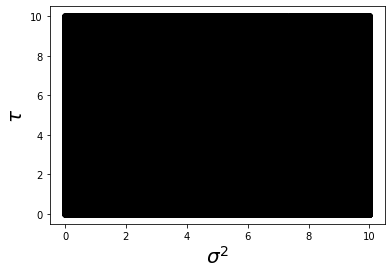

In [7]:
plt.plot(sample_sigma2, sample_tau, 'o', color = 'black')
plt.xlabel(r'$\sigma^2$', fontsize=20)
plt.ylabel(r'$\tau$', fontsize=20)

In [8]:
def get_r(x1, x2):
    return np.subtract.outer(x1, x2)

def matern_kernel(r, tau, sigma2, v = 3/2):
    # see https://zhuhao.org/post/gp_python_r/
    r = np.abs(r)
    r[r == 0] = 1e-8
    part1 = 2 ** (1 - v) / gamma(v)
    part2 = (np.sqrt(2 * v) * r / tau) ** v
    part3 = sigma2*kv(v, np.sqrt(2 * v) * r / tau)
    return part1 * part2 * part3

def GP(xs_train, ys_train, xs_test, ys_test, tau, sigma2):
    Y_train = np.expand_dims(ys_train, axis=1)
    
    K = matern_kernel(get_r(xs_train, xs_train), tau, sigma2)
    Kstar = matern_kernel(get_r(xs_test, xs_train), tau, sigma2)
    Kstarstar = matern_kernel(get_r(xs_test, xs_test), tau, sigma2)
    Ystar = Kstar@(np.linalg.inv(K))@Y_train
    #Sigmastarstar = Kstarstar - Kstar@(np.linalg.inv(K))@Kstar.T
    return Ystar

def L2(x1, x2):
    return np.mean(np.sqrt(x1**2+x2**2))

In [9]:
taus = []
sigma2s = []
for i in range(N_samples):    
    tau = sample_tau[i]
    sigma2 = sample_sigma2[i]
    ystar = GP(xs_train, ys_train, xs_test, ys_test, tau, sigma2)
    loss = L2(ystar, ys_test)
    if loss < 4:
        taus.append(tau)
        sigma2s.append(sigma2)

In [10]:
len(taus)

96498

In [11]:
sigma2s = np.vstack(sigma2s).T
taus = np.vstack(taus).T

Text(0, 0.5, 'count')

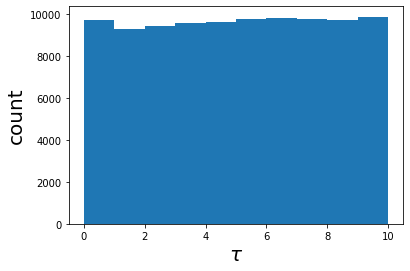

In [12]:
plt.hist(taus[6,:]);
plt.xlabel(r'$\tau$', fontsize = 20)
plt.ylabel(r'count', fontsize = 20)

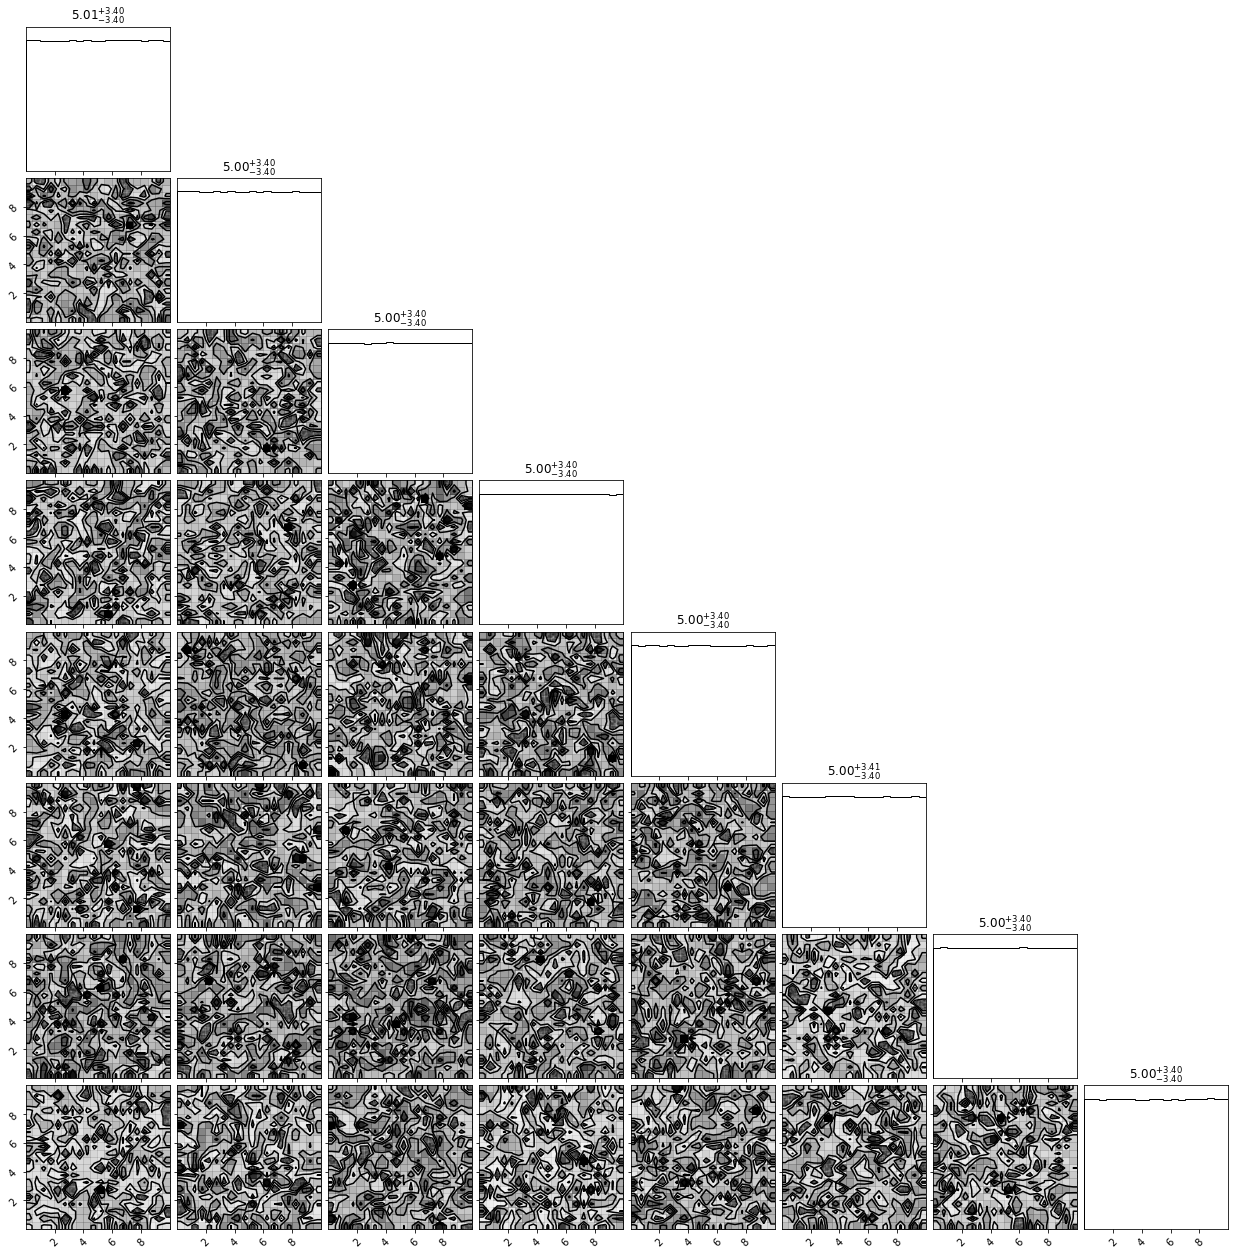

In [13]:
# posterior for sigma2
figure = corner.corner(
    sigma2s.T,
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

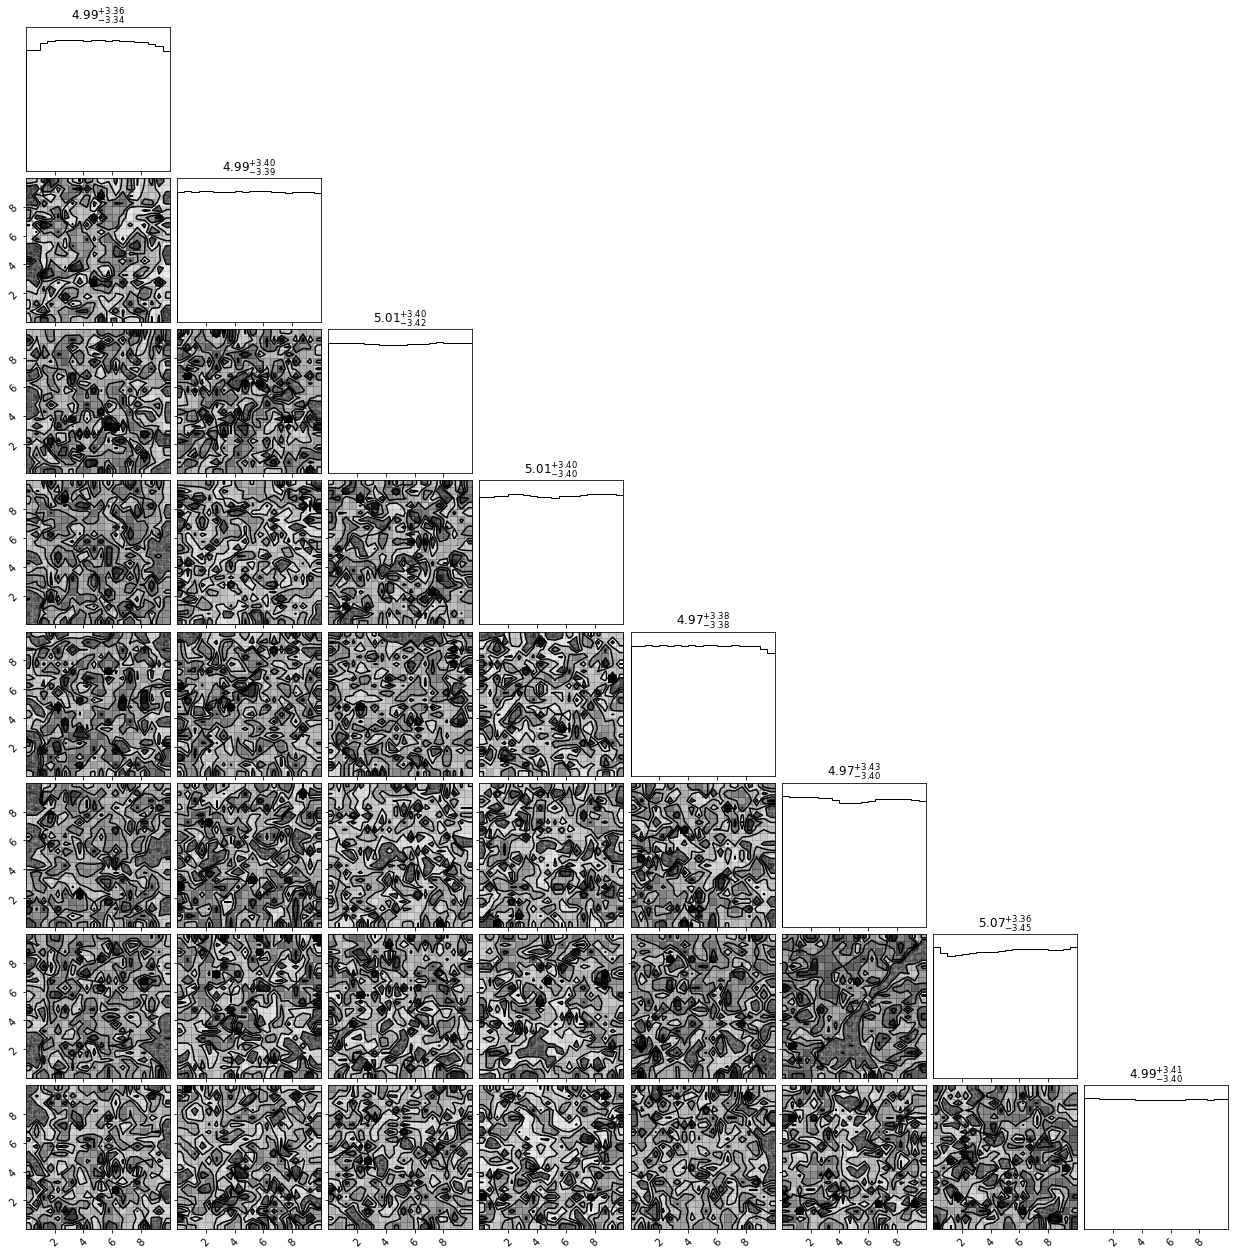

In [14]:
# posterior for tau
figure = corner.corner(
    taus.T,
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

#### Part 2: Re-do the regression of Problem Set 5, Problem 1, but now using a neural network. Either build your own, or else use a canned implementation from jax, pytorch, TensorFlow, or scikit-learn. Compare your results to your Problem Set 5 results. The deep learning results will be substantially better, right?

In the below I implement a simple CNN. It looks like the non-deep learning was better, but I bet I could improve this CNN if I spent more time testing out different architectures.

In [15]:

data_dir = "../Downloads/"
tr_file  = "ap17_xpcont_train_prtcl3.pickle"
val_file = "ap17_xpcont_validation_prtcl3.pickle"


with open(data_dir+tr_file, 'rb') as f1:
    data_tr = pickle.load(f1)

with open(data_dir+val_file, 'rb') as f2:
    data_val = pickle.load(f2)
    
    
print("Keys of training set and validation set are:")
print(data_tr.keys(), "\n", data_val.keys())

print("array shape of traing set and validation set are:")
print([data_tr[_].shape for _ in data_tr.keys()], "\n", [data_val[_].shape for _ in data_val.keys()])


Keys of training set and validation set are:
dict_keys(['bp_coef', 'rp_coef', 'labels']) 
 dict_keys(['bp_coef', 'rp_coef', 'labels'])
array shape of traing set and validation set are:
[(4000, 55), (4000, 55), (4000, 2)] 
 [(1000, 55), (1000, 55), (1000, 2)]


In [16]:
bp = data_tr['bp_coef']
rp = data_tr['rp_coef']
teff = data_tr['labels'][:,0]
data_xs = np.dstack((bp, rp)) # shape 1000x55x2
data_xs /= np.max(data_xs) # shape 1000
data_ys = teff

bp_val = data_val['bp_coef']
rp_val = data_val['rp_coef']
teff_val = data_val['labels'][:,0]
data_xs_val = np.dstack((bp_val, rp_val))
data_xs_val /= np.max(data_xs_val)
data_ys_val = teff_val
shape = data_xs_val[0].shape

In [17]:

model_4 = tf.keras.Sequential([
    tf.keras.Input(shape=shape),
    tf.keras.layers.Conv1D(32, 2, activation='relu',),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1),
])



In [18]:
model_4.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(data_xs, data_ys, epochs=2000, verbose=1)

Train on 4000 samples
Epoch 1/2000
4000/4000 [==============================] - 1s 199us/sample - loss: 3298.2342
Epoch 2/2000
4000/4000 [==============================] - 0s 76us/sample - loss: 359.6192
Epoch 3/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 290.6148
Epoch 4/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 253.0905
Epoch 5/2000
4000/4000 [==============================] - 0s 72us/sample - loss: 236.5581
Epoch 6/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 228.8294
Epoch 7/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 221.1948
Epoch 8/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 217.4767
Epoch 9/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 209.1304
Epoch 10/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 204.0601
Epoch 11/2000
4000/4000 [==============================] - 0s 74us/sample -

4000/4000 [==============================] - 0s 74us/sample - loss: 133.7699
Epoch 91/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 133.2086
Epoch 92/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 134.9962
Epoch 93/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 133.8688
Epoch 94/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 131.3239
Epoch 95/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 138.2035
Epoch 96/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 128.4099
Epoch 97/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 129.7376
Epoch 98/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 129.4621
Epoch 99/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 129.7594
Epoch 100/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 128.8645
Epoch 101/20

4000/4000 [==============================] - 0s 74us/sample - loss: 102.3548
Epoch 180/2000
4000/4000 [==============================] - 0s 77us/sample - loss: 104.8954
Epoch 181/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 101.4536
Epoch 182/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 107.0683
Epoch 183/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 105.1494
Epoch 184/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 102.8047
Epoch 185/2000
4000/4000 [==============================] - 0s 72us/sample - loss: 102.0991
Epoch 186/2000
4000/4000 [==============================] - 0s 72us/sample - loss: 101.1582
Epoch 187/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 101.2377
Epoch 188/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 102.6665
Epoch 189/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 99.6225
Epoc

4000/4000 [==============================] - 0s 75us/sample - loss: 88.8980
Epoch 270/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 91.2654
Epoch 271/2000
4000/4000 [==============================] - 0s 72us/sample - loss: 88.3951
Epoch 272/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 92.4206
Epoch 273/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 90.0777
Epoch 274/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 87.4806
Epoch 275/2000
4000/4000 [==============================] - 0s 76us/sample - loss: 91.0214
Epoch 276/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 89.5307
Epoch 277/2000
4000/4000 [==============================] - 0s 72us/sample - loss: 90.4190
Epoch 278/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 88.5130
Epoch 279/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 88.3893
Epoch 280/2000

4000/4000 [==============================] - 0s 75us/sample - loss: 80.1340
Epoch 360/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 79.4268
Epoch 361/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 80.8816
Epoch 362/2000
4000/4000 [==============================] - 0s 72us/sample - loss: 80.0456
Epoch 363/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 78.7471
Epoch 364/2000
4000/4000 [==============================] - 0s 78us/sample - loss: 82.4417
Epoch 365/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 81.6331
Epoch 366/2000
4000/4000 [==============================] - 0s 76us/sample - loss: 78.1348
Epoch 367/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 79.6051
Epoch 368/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 78.9441
Epoch 369/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 79.9188
Epoch 370/2000

4000/4000 [==============================] - 0s 74us/sample - loss: 72.3983
Epoch 450/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 73.1836
Epoch 451/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 74.9965
Epoch 452/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 73.6878
Epoch 453/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 73.1018
Epoch 454/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 74.7584
Epoch 455/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 70.7903
Epoch 456/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 74.0755
Epoch 457/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 70.3345
Epoch 458/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 70.5655
Epoch 459/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 74.0730
Epoch 460/2000

4000/4000 [==============================] - 0s 74us/sample - loss: 69.6981
Epoch 540/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 68.4556
Epoch 541/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 72.6165
Epoch 542/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 68.6567
Epoch 543/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 72.1970
Epoch 544/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 73.1715
Epoch 545/2000
4000/4000 [==============================] - 0s 72us/sample - loss: 71.9143
Epoch 546/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 68.0549
Epoch 547/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 68.2517
Epoch 548/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 69.0558
Epoch 549/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 72.4358
Epoch 550/2000

4000/4000 [==============================] - 0s 73us/sample - loss: 67.1001
Epoch 630/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 64.2476
Epoch 631/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 67.0598
Epoch 632/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 69.0393s - loss: 6
Epoch 633/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 65.9955
Epoch 634/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 69.3817
Epoch 635/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 66.1215
Epoch 636/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 66.8155
Epoch 637/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 67.1500
Epoch 638/2000
4000/4000 [==============================] - 0s 78us/sample - loss: 71.6126
Epoch 639/2000
4000/4000 [==============================] - 0s 77us/sample - loss: 63.9655
Epo

4000/4000 [==============================] - 0s 86us/sample - loss: 65.8176
Epoch 720/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 66.8821
Epoch 721/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 63.6837
Epoch 722/2000
4000/4000 [==============================] - 0s 79us/sample - loss: 64.9768
Epoch 723/2000
4000/4000 [==============================] - 0s 76us/sample - loss: 65.4660
Epoch 724/2000
4000/4000 [==============================] - 0s 76us/sample - loss: 65.2891
Epoch 725/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 63.6489
Epoch 726/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 65.7807
Epoch 727/2000
4000/4000 [==============================] - 0s 79us/sample - loss: 65.3438
Epoch 728/2000
4000/4000 [==============================] - 0s 81us/sample - loss: 62.3346
Epoch 729/2000
4000/4000 [==============================] - 0s 76us/sample - loss: 64.2193
Epoch 730/2000

4000/4000 [==============================] - 0s 73us/sample - loss: 62.5951
Epoch 810/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 61.6926
Epoch 811/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 62.0345
Epoch 812/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 63.0660
Epoch 813/2000
4000/4000 [==============================] - 0s 76us/sample - loss: 62.6937
Epoch 814/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 60.9379
Epoch 815/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 63.9782
Epoch 816/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 64.2473
Epoch 817/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 66.8484
Epoch 818/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 62.7975
Epoch 819/2000
4000/4000 [==============================] - 0s 74us/sample - loss: 60.6338
Epoch 820/2000

4000/4000 [==============================] - 0s 75us/sample - loss: 61.9527
Epoch 900/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 62.5507
Epoch 901/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 65.2188
Epoch 902/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 61.5576
Epoch 903/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 61.2693
Epoch 904/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 61.8021
Epoch 905/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 63.7229
Epoch 906/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 61.5997
Epoch 907/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 60.4478
Epoch 908/2000
4000/4000 [==============================] - 0s 72us/sample - loss: 59.9644
Epoch 909/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 60.6260
Epoch 910/2000

4000/4000 [==============================] - 0s 67us/sample - loss: 59.7712
Epoch 990/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 63.1493
Epoch 991/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 61.0377
Epoch 992/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 58.9382
Epoch 993/2000
4000/4000 [==============================] - 0s 66us/sample - loss: 60.2016
Epoch 994/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 62.0093
Epoch 995/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 61.6739
Epoch 996/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 63.6592
Epoch 997/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 60.3601
Epoch 998/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 61.9957
Epoch 999/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 61.7377
Epoch 1000/200

4000/4000 [==============================] - 0s 68us/sample - loss: 59.4425
Epoch 1079/2000
4000/4000 [==============================] - 0s 71us/sample - loss: 61.5713
Epoch 1080/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 59.2295
Epoch 1081/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 60.5692
Epoch 1082/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 61.2829
Epoch 1083/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 59.7991
Epoch 1084/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 57.9170
Epoch 1085/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 58.2396
Epoch 1086/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 59.0618
Epoch 1087/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 56.8990
Epoch 1088/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 59.7062
Epoc

4000/4000 [==============================] - 0s 67us/sample - loss: 58.5132
Epoch 1168/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 58.0327
Epoch 1169/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 58.3886
Epoch 1170/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 57.5693
Epoch 1171/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 55.0615
Epoch 1172/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 57.0321
Epoch 1173/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 57.3178
Epoch 1174/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 62.1532
Epoch 1175/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 57.6980
Epoch 1176/2000
4000/4000 [==============================] - 0s 73us/sample - loss: 57.3762
Epoch 1177/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 59.1898
Epoc

4000/4000 [==============================] - 0s 67us/sample - loss: 56.7349
Epoch 1257/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 57.2600
Epoch 1258/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 58.0167
Epoch 1259/2000
4000/4000 [==============================] - 0s 66us/sample - loss: 56.5114
Epoch 1260/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 56.4329
Epoch 1261/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 58.4520
Epoch 1262/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 61.2569
Epoch 1263/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 56.4585
Epoch 1264/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 54.9541
Epoch 1265/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 57.8051
Epoch 1266/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 57.3724
Epoc

4000/4000 [==============================] - 0s 67us/sample - loss: 56.7233
Epoch 1346/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 56.0981
Epoch 1347/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 56.3013
Epoch 1348/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 56.3548
Epoch 1349/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.7798
Epoch 1350/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 55.7262
Epoch 1351/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.3099
Epoch 1352/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.5749
Epoch 1353/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 55.1468
Epoch 1354/2000
4000/4000 [==============================] - 0s 66us/sample - loss: 54.2258
Epoch 1355/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 56.5283
Epoc

4000/4000 [==============================] - 0s 67us/sample - loss: 54.2351
Epoch 1435/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 56.1522
Epoch 1436/2000
4000/4000 [==============================] - 0s 69us/sample - loss: 56.1451
Epoch 1437/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 57.0001
Epoch 1438/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 55.5319
Epoch 1439/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.4611
Epoch 1440/2000
4000/4000 [==============================] - 0s 69us/sample - loss: 54.3311
Epoch 1441/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 55.3480
Epoch 1442/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 53.9623
Epoch 1443/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 57.7372
Epoch 1444/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.3844
Epoc

4000/4000 [==============================] - 0s 68us/sample - loss: 52.5300
Epoch 1524/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 55.1822
Epoch 1525/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 53.5401
Epoch 1526/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.0029
Epoch 1527/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.6383
Epoch 1528/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 53.4944
Epoch 1529/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 57.7745
Epoch 1530/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.7021
Epoch 1531/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 53.6612
Epoch 1532/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 56.0962
Epoch 1533/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 56.5353
Epoc

4000/4000 [==============================] - 0s 67us/sample - loss: 54.9636
Epoch 1613/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 55.0728
Epoch 1614/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 55.0640
Epoch 1615/2000
4000/4000 [==============================] - 0s 66us/sample - loss: 53.0060
Epoch 1616/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 55.0643
Epoch 1617/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.7946
Epoch 1618/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.5176
Epoch 1619/2000
4000/4000 [==============================] - 0s 71us/sample - loss: 54.4223
Epoch 1620/2000
4000/4000 [==============================] - 0s 70us/sample - loss: 53.0483
Epoch 1621/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.2724
Epoch 1622/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.6632
Epoc

4000/4000 [==============================] - 0s 66us/sample - loss: 54.1187
Epoch 1702/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 53.2719
Epoch 1703/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 52.9668
Epoch 1704/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 56.9380
Epoch 1705/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 53.4342
Epoch 1706/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.0513
Epoch 1707/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 53.0193
Epoch 1708/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 52.9413
Epoch 1709/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 54.6438
Epoch 1710/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 54.2069
Epoch 1711/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 52.8749
Epoc

4000/4000 [==============================] - 0s 67us/sample - loss: 53.8645
Epoch 1791/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 52.4667
Epoch 1792/2000
4000/4000 [==============================] - 0s 75us/sample - loss: 51.2980
Epoch 1793/2000
4000/4000 [==============================] - 0s 69us/sample - loss: 51.7966
Epoch 1794/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 52.2946
Epoch 1795/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 51.2730
Epoch 1796/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 53.5469
Epoch 1797/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 51.8949
Epoch 1798/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 51.3739
Epoch 1799/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 51.9858
Epoch 1800/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 51.8596
Epoc

4000/4000 [==============================] - 0s 70us/sample - loss: 51.2981
Epoch 1880/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 52.4579
Epoch 1881/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 53.2137
Epoch 1882/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 51.5169
Epoch 1883/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 52.2909
Epoch 1884/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 49.7093
Epoch 1885/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 51.9989
Epoch 1886/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 51.9608
Epoch 1887/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 51.0852
Epoch 1888/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 52.2808
Epoch 1889/2000
4000/4000 [==============================] - 0s 66us/sample - loss: 50.5080
Epoc

4000/4000 [==============================] - 0s 68us/sample - loss: 51.1249
Epoch 1969/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 50.9353
Epoch 1970/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 50.1416
Epoch 1971/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 52.7126
Epoch 1972/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 50.7409
Epoch 1973/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 50.5735
Epoch 1974/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 52.6462
Epoch 1975/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 52.0353
Epoch 1976/2000
4000/4000 [==============================] - 0s 68us/sample - loss: 50.3280
Epoch 1977/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 50.6196
Epoch 1978/2000
4000/4000 [==============================] - 0s 67us/sample - loss: 53.4130
Epoc

In [19]:
preds = model_4.predict(data_xs_val)

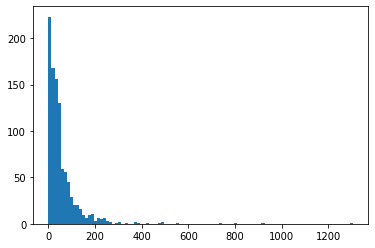

In [20]:
plt.hist(np.abs(data_ys_val-np.vstack(preds).flatten()), bins = 100);